In [162]:
import numpy as np   #importing libraries
import simpy 
import queue
import random
import random as rd
import matplotlib 
from matplotlib import pyplot as plt
#rd.seed(2)

In [163]:
global SZ,CP,RM
SZ=[]
CP=[]
RM=[]
N=1000
k=15
state=[]
#Lambda = 10
#mu = 1.5
alpha = 0.5
gamma = 0.9
#t = 0   #system clock
t1=0
t2=0
t_lambda = 0 #poisson random variable used to generate next service time
t_mu = 0  #poisson random variable used to generate next departure time
t_a=0
wait=0
R=1000
transmission_time=0
l="0"
P_transmission=500
P_idle=100

episodes = 10
SHOW_EVERY = 100
STATS_EVERY=100

Q_dict=dict()
L=[]

action_list=()

In [164]:
class Packet(object):
    def __init__(self, time, id, mobileID, seeed):
        
        self.time=time                                                
        self.id=id
        self.mobileID=mobileID   
        self.size=random.randint(200,400) #seed 1 op 2, seed 2 op 
        SZ.append(round(self.size,2))
        self.cpucycle=random.uniform(100,1900)
        self.ram=random.randint(1, 32) #seed 1 op 3, seed 2 op 1, seed 3 op 4
        RM.append(round(self.ram,2))

class mobile(object): #mobile class with an ID              
    def __init__(self, ID):
        self.ID=ID
        self.pot=int(1)
        
    #generates packets and sends via out_pipe
    def packet_generator_initial(self, numPackets, env, out_pipe, task_id,send): 
        
        yield env.timeout(send)
        #print("sending task {} of mobile {} at time {}".format(task_id, self.ID, env.now))
        p=Packet(env.now, task_id, self.ID, self.pot)
        self.pot+=1
        if(self.pot==4):
                self.pot=1
        yield out_pipe.put(p)
        
    def packet_generator(self, numPackets, env, out_pipe, task_id,send,pipe4,currentpipe): 
        
        yield env.timeout(send)
        #print("sending task {} of mobile {} at time {}".format(task_id, self.ID, env.now))
        p=Packet(env.now, task_id, self.ID, self.pot)
        self.pot+=1
        if(self.pot==4):
                self.pot=1
        yield out_pipe.put(p)
        
        state=yield pipe4.get()
        yield currentpipe.put(state)



In [165]:
 def reward_generator(T,cpu):
    cpuU=cpu*0.5
    cpusla=680
    Tsla=2 
    Nsla=3
    Gsla=3  
    Cost_sla=50
    Cg=0
    Ct=0
    Cn=0
    Cost_n=0
    Cp=0
    
    #if (G<Gsla):
        #Cg=-5*(Gsla/G)
    if (cpuU<cpusla):
        Cp=-3* (cpusla/cpuU)
    if (T>Tsla):
        Ct = -5 * (T/Tsla)
    #if (N>Nsla):
        #Cn=-5*(N/Nsla)
    #if (cost>Cost_sla):
        #Cost_n=-5*(cost/Cost_sla)
    r2=(cpuU/cpusla)+Cp
    Reward = (Tsla/T) + Ct + r2  #Reward Function
    return Reward

In [166]:
class Fog(object):      
    def __init__(self, ID):
        self.ID=ID
        self.cpuspeed=0
        self.cpucycle=0
        self.R=0
        self.Number_queue=1
        self.lost=0
        self.transmission_time=0
        self.response_time=0
        self.server_count=0
        self.wait=0
        self.taskinqueue=0
        self.a=0
        self.time=0
        self.neighbour1=None
        self.neighbour2=None
        
        self.service_time=[]
        self.response_time_list=[]
        self.Serverqueue=[]
        self.total_serverqueue=[]
        self.waitlist=[]
        self.energy_offloading=[]
        self.reward_list=[]
        self.state=[]
        self.observation_space_discretesize = [11, 11, 2]
        self.q_table = np.random.uniform(low=0, high=0, size=(self.observation_space_discretesize))
    
        
    def Neighbour(self,neighbour1,neighbour2):
        self.neighbour1=neighbour1
        self.neighbour2=neighbour2

    def Calculate_Q_value(self,prevoius_state,next_state,reward):

      val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5]),prevoius_state[6]))
      nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5]),0))
      nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5]),1))
      nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5]),2))
    
#       val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3]))
#       nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2]),0))
#       nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2]),1))
#       nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2]),2))
        
      
      if nxt_val_1==None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=0
      elif nxt_val_1==None and nxt_val_2==None and nxt_val_3!=None:
          nxt_val=nxt_val_3
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3==None:
          nxt_val=nxt_val_2
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=nxt_val_1
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3==None:
          if nxt_val_1>=nxt_val_2:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_2
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_2 and nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          elif nxt_val_2>nxt_val_1 and nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          elif nxt_val_3>nxt_val_1 and nxt_val_3>nxt_val_2:
              nxt_val=nxt_val_3
      
      if val==None:
          val=0
                        
      target=reward+gamma*nxt_val
      
      Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5]),prevoius_state[6])]=val+alpha*(target-val)
      #Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3])]=val+alpha*(target-val)  
    
    def FOG(self, env, server, in_pipe,mobile,pipe4):
        
         msg = yield in_pipe.get()
         self.cpuspeed=random.uniform(1000,1500)
         #print("FOg",self.ID,"cPU",self.cpuspeed)
         self.R=random.uniform(900,1100)
        
         state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.ID,msg.id])   # CURRENT STATE for calaculatin Q VALU
         #state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.ID,msg.id])  
        
         discrete_state=()
         discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue,self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed)
         #discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue)
        
         yield pipe4.put(discrete_state) # CURRENT STATE
            
         self.transmission_time = (msg.size/self.R)
         #print("transmits task {} to need time {}".format(msg.id,transmission_time,self.ID))
         yield env.timeout(self.transmission_time)
         a=env.now
         #print("Arrived task {} at time {} at FOG {} from mobile {}".format(msg.id,a,self.ID,mobile))
         #print("server",self.server_count)
         #print("present q",self.taskinqueue)

         if self.server_count==5:
            if len(self.Serverqueue)<k:
               self.Serverqueue.append(msg)
               self.taskinqueue=len(self.Serverqueue)
               #print("queue te ase ",len(self.Serverqueue))
               #print("task ase queue te ase ",taskinqueue)
               self.Number_queue = self.Number_queue + 1
               #self.server_count=0
            else:
                self.lost=self.lost+1 
                return  

        
#          u=rd.random()
#          t_mu=-np.log(u)/mu
#          self.service_time.append(t_mu)
#          #print("service time",t_mu)
           
         t_mu=msg.cpucycle/self.cpuspeed
         self.service_time.append(t_mu)
         #print(t_mu)
         
         E = (P_transmission * self.transmission_time) + (P_idle * t_mu)
         self.energy_offloading.append(E)
         
         #print("present a queue te ase ",len(self.Serverqueue))
         #print("Fog:   Fog",self.ID,"mobile",mobile,", akhon queue te ase ",self.taskinqueue,", time",env.now)

         with server.request() as req:
             yield req
             s=env.now
             self.wait=s-a
             if len(self.Serverqueue)>0:
                 self.Serverqueue.pop(0)
             #self.total_serverqueue.append(len(self.Serverqueue))
             #print("queue",len(self.Serverqueue))
             #print("wait",self.wait)
             #print("Starting service task {} at time {} at FOG {}".format(msg.id,s,self.ID))
             #print("Waiting time of task {} at time {} at FOG {}".format(msg.id,self.wait,self.ID))
             self.waitlist.append(self.wait)
             self.response_time=self.wait+t_mu+self.transmission_time
             self.response_time_list.append(self.response_time)
             
             self.server_count=self.server_count+1
             yield env.timeout(t_mu)
             #print("Finish service task {} at time {} at FOG {}".format(msg.id,env.now,self.ID))
             self.server_count=self.server_count-1   
           
             r=reward_generator(self.response_time,self.cpuspeed)
             self.reward_list.append(r)
             #print("r",r)
            
             new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed]
             #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
             for i in state:
               if i[7]==msg.id:
               #if i[4]==msg.id:
                 self.Calculate_Q_value(i,new_state,r)
                 break
                
             #yield rewardpipe.put(r)
                

             #discrete_state2=()
             #print("next q",self.taskinqueue)
             #state.append([self.ID,mobile,self.taskinqueue,env.now,self.neighbour1.ID,self.neighbour1.taskinqueue])
             #discrete_state2=(self.taskinqueue,self.neighbour1.taskinqueue,self.cpuspeed,self.neighbour1.cpuspeed)
             #yield pipe3.put(state)
             #yield pipe3.put(discrete_state2)
             #print("Fog",self.ID,"pore queue te ase ",self.taskinqueue,"time hoitese",env.now)
    
    def nextstate(self,env,mobile,pipe4,rewardpipe,action,statepipe):
        
        discrete_state_action=(0,0,0)
        #print("update q table",self.q_table)

        action=np.argmax(self.q_table[discrete_state_action[0],discrete_state_action[1]])
        action_list=(discrete_state_action[0],discrete_state_action[1],action)
        yield statepipe.put(discrete_state_action)
        #print("q valu",self.q_table[discrete_state_action[0],discrete_state_action[1]])
        #print("Q-LEARNING onujae action neya uchit",action_list)
        r=yield rewardpipe.get()
        #next_state = yield pipe3.get()
        #print("next state,time",next_state,env.now)
        current_q = self.q_table[discrete_state_action]
        max_future_q = np.max(self.q_table[next_state])
        new_q = current_q + alpha * (r + gamma * max_future_q - current_q )
        self.q_table[discrete_state_action] = new_q
 
        

In [167]:
class Decision(object):
    def __init__(self, ID):
        self.ID=ID
        self.fog1_count=0
        self.fog2_count=0
        self.fog3_count=0
        self.t1=0
        self.t2=0
        self.t3=0
        self.t4=0
        self.statetime=0
        self.current=()
    def decision(self,env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe):
        yield env1.timeout(0)

        
        #for j in range(10):
        
        if(i==0):
                 self.fog1_count=self.fog1_count+1           
                 u=rd.random()
                 t_lambda=-np.log(u)/Lambda
                 t_a=self.t1+t_lambda
                 self.t1=t_a
                 env1.process(ms1.packet_generator_initial(1, env1, pipe1, 0,t_a))
                 env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                 #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,0,statepipe))
                    
                
        for j in range(1):
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t1+t_lambda
            self.t1=t_a
            env1.process(ms1.packet_generator(1, env1, pipe1, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t2+t_lambda
            self.t2=t_a
            env1.process(ms2.packet_generator(1, env1, pipe2, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t3+t_lambda
#             self.t3=t_a
#             env1.process(ms3.packet_generator(1, env1, pipe3, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t4+t_lambda
#             self.t4=t_a
#             env1.process(ms4.packet_generator(1, env1, pipe5, i,t_a,pipe4,currentpipe))

#             current2=yield currentpipe.get()
#             #print("time, current state, i: ",env1.now,current2,i)
            
#             action1=Q_dict.get((current2,0))
#             action2=Q_dict.get((current2,1))
#             action3=Q_dict.get((current2,2))
            
#             if action1==None and action2==None and action3==None:
#               action=random.randint(0,2)
            
#             elif action1!=None and action2==None and action3==None:
#               action=0     
#             elif action1==None and action2!=None and action3==None:
#               action=1
#             elif action1==None and action2==None and action3!=None:
#               action=2
            
#             elif action1!=None and action2!=None and action3==None:
#               if action1>action2:
#                 action=0
#               else:
#                 action=1
#             elif action1==None and action2!=None and action3!=None:
#               if action2>action3:
#                 action=1
#               else:
#                 action=2
#             elif action1!=None and action2==None and action3!=None:
#               if action1>action3:
#                 action=0
#               else:
#                 action=2
                
#             elif action1!=None and action2!=None and action3!=None:
#               if action1>action2 and action1>action3:
#                 action=0
#               if action2>action1 and action2>action3:
#                 action=1
#               if action3>action1 and action3>action2:
#                 action=2
#             elif action1==action2 or action2==action3 or action1==action3:
#                 action=random.randint(0,2)
            
            action=random.randint(0,2)
            
            if(action==0):
                    
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe5,ms4.ID,pipe4))
                            
            if(action==1):
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog1.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog1.FOG(env1, server2, pipe5,ms4.ID,pipe4))
 
            if(action==2):
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           




In [168]:
avg_response_time=[]
avg_energy=[]

random_response_time=[]
random_energy=[]
for Lambda in range(5,16):
    env1 = simpy.Environment()    
    server1 = simpy.Resource(env1, capacity=5)
    server2 = simpy.Resource(env1, capacity=5)
    server3 = simpy.Resource(env1, capacity=5)
    rd.seed(2)

    pipe1 = simpy.Store(env1)
    pipe2 = simpy.Store(env1)
    pipe3 = simpy.Store(env1)
    pipe4 = simpy.Store(env1)
    pipe5 = simpy.Store(env1)
    statepipe = simpy.Store(env1)
    currentpipe = simpy.Store(env1)

    ms1=mobile(1)
    ms2=mobile(2)
    ms3=mobile(3)
    ms4=mobile(4)

    fog1 = Fog(0)
    fog2 = Fog(1)
    fog3=Fog(2)

    fog1.Neighbour(fog2,fog3)
    fog2.Neighbour(fog1,fog3)
    fog3.Neighbour(fog1,fog2)
    

    obj=Decision(1)
    #Lambda=10
    #print("YO",Lambda)
    for i in range(N):
        env1.process(obj.decision(env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe))
    env1.run()

    #print("after simulation q_table",q_table)
    #print("after simulation present state and action",action_list)

    fog1_count=obj.fog1_count
    fog2_count=obj.fog2_count
    fog3_count=obj.fog3_count
    fog1_count=fog1_count-fog1.lost
    fog2_count=fog2_count-fog2.lost
    fog3_count=fog3_count-fog3.lost

    #print("lost",fog1.lost,fog2.lost,fog3.lost)
    #print("present count",fog1_count,fog2_count,fog3_count)
    avgwaittime=sum(fog1.waitlist)/fog1_count
    #print("FOG-1 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog1.service_time)/fog1_count
    #print("FOG-1 Average service time:", avgservicetime)
    avgsystemtime1=sum(fog1.response_time_list)/fog1_count
    #print("FOG-1 Average response time:", avgsystemtime1)
    avgenergy1=sum(fog1.energy_offloading)/fog1_count
    #print("FOG-1 Average Energy consumption:", avgenergy1)
    
    avg_response_time.append(avgsystemtime1)
    avg_energy.append(avgenergy1)
    
    avgwaittime=sum(fog2.waitlist)/fog2_count
    #print("FOG-2 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog2.service_time)/fog2_count
    #print("FOG-2 Average service time:", avgservicetime)
    avgsystemtime2=sum(fog2.response_time_list)/fog2_count
    #print("FOG-2 Average response time:", avgsystemtime2)
    avgenergy2=sum(fog2.energy_offloading)/fog2_count
    #print("FOG-2 Average Energy consumption:", avgenergy2)
    
    avg_response_time.append(avgsystemtime2)
    avg_energy.append(avgenergy2)

    avgwaittime=sum(fog3.waitlist)/fog3_count
    #print("FOG-3 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog3.service_time)/fog3_count
    #print("FOG-3 Average service time:", avgservicetime)
    avgsystemtime3=sum(fog3.response_time_list)/fog3_count
    #print("FOG-3 Average response time:", avgsystemtime3)
    avgenergy3=sum(fog3.energy_offloading)/fog3_count
    
    avg_response_time.append(avgsystemtime3)
    avg_energy.append(avgenergy3)


#print(avg_response_time)
s=0
for i in range(0,33,3):
    s=(avg_response_time[i]+avg_response_time[i+1]+avg_response_time[i+2])/3
    random_response_time.append(s)


#plt.ylabel("Response Time")
#plt.xlabel("lambda")
#plt.show()



In [169]:
class Decision(object):
    def __init__(self, ID):
        self.ID=ID
        self.fog1_count=0
        self.fog2_count=0
        self.fog3_count=0
        self.t1=0
        self.t2=0
        self.t3=0
        self.t4=0
        self.statetime=0
        self.current=()
    def decision1(self,env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe):
        yield env1.timeout(0)

        
        #for j in range(10):
        
        if(i==0):
                 self.fog1_count=self.fog1_count+1           
                 u=rd.random()
                 t_lambda=-np.log(u)/Lambda
                 t_a=self.t1+t_lambda
                 self.t1=t_a
                 env1.process(ms1.packet_generator_initial(1, env1, pipe1, 0,t_a))
                 env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                 #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,0,statepipe))
                    
                
        for j in range(1):
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t1+t_lambda
            self.t1=t_a
            env1.process(ms1.packet_generator(1, env1, pipe1, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t2+t_lambda
            self.t2=t_a
            env1.process(ms2.packet_generator(1, env1, pipe2, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t3+t_lambda
#             self.t3=t_a
#             env1.process(ms3.packet_generator(1, env1, pipe3, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t4+t_lambda
#             self.t4=t_a
#             env1.process(ms4.packet_generator(1, env1, pipe5, i,t_a,pipe4,currentpipe))

            current2=yield currentpipe.get()
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            #action=random.randint(0,2)
            
            if(action==0):
                    
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe5,ms4.ID,pipe4))
                            
            if(action==1):
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog1.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog1.FOG(env1, server2, pipe5,ms4.ID,pipe4))
 
            if(action==2):
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           




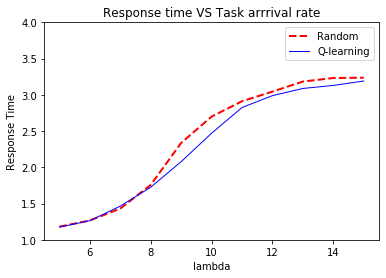

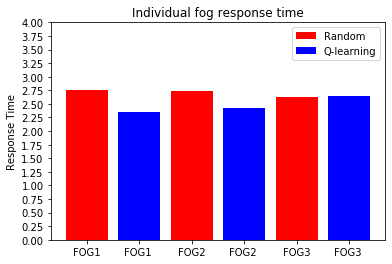

In [170]:
avg_response_time2=[]
avg_energy2=[]

random_response_time2=[]
random_energy2=[]
for Lambda in range(5,16):
    env1 = simpy.Environment()    
    server1 = simpy.Resource(env1, capacity=5)
    server2 = simpy.Resource(env1, capacity=5)
    server3 = simpy.Resource(env1, capacity=5)
    rd.seed(2)

    pipe1 = simpy.Store(env1)
    pipe2 = simpy.Store(env1)
    pipe3 = simpy.Store(env1)
    pipe4 = simpy.Store(env1)
    pipe5 = simpy.Store(env1)
    statepipe = simpy.Store(env1)
    currentpipe = simpy.Store(env1)

    ms1=mobile(1)
    ms2=mobile(2)
    ms3=mobile(3)
    ms4=mobile(4)

    fog1 = Fog(0)
    fog2 = Fog(1)
    fog3=Fog(2)

    fog1.Neighbour(fog2,fog3)
    fog2.Neighbour(fog1,fog3)
    fog3.Neighbour(fog1,fog2)
    

    obj=Decision(1)
    #Lambda=10
    #print("YO",Lambda)
    for i in range(N):
        env1.process(obj.decision1(env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe))
    env1.run()

    #print("after simulation q_table",q_table)
    #print("after simulation present state and action",action_list)

    fog1_count=obj.fog1_count
    fog2_count=obj.fog2_count
    fog3_count=obj.fog3_count
    fog1_count=fog1_count-fog1.lost
    fog2_count=fog2_count-fog2.lost
    fog3_count=fog3_count-fog3.lost

    #print("lost",fog1.lost,fog2.lost,fog3.lost)
    #print("present count",fog1_count,fog2_count,fog3_count)
    avgwaittime=sum(fog1.waitlist)/fog1_count
    #print("FOG-1 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog1.service_time)/fog1_count
    #print("FOG-1 Average service time:", avgservicetime)
    avgsystemtime1=sum(fog1.response_time_list)/fog1_count
    #print("FOG-1 Average response time:", avgsystemtime1)
    avgenergy1=sum(fog1.energy_offloading)/fog1_count
    #print("FOG-1 Average Energy consumption:", avgenergy1)
    
    avg_response_time2.append(avgsystemtime1)
    avg_energy2.append(avgenergy1)
    

    avgwaittime=sum(fog2.waitlist)/fog2_count
    #print("FOG-2 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog2.service_time)/fog2_count
    #print("FOG-2 Average service time:", avgservicetime)
    avgsystemtime2=sum(fog2.response_time_list)/fog2_count
    #print("FOG-2 Average response time:", avgsystemtime2)
    avgenergy2=sum(fog2.energy_offloading)/fog2_count
    #print("FOG-2 Average Energy consumption:", avgenergy2)
    
    avg_response_time2.append(avgsystemtime2)
    avg_energy2.append(avgenergy2)

    avgwaittime=sum(fog3.waitlist)/fog3_count
    #print("FOG-3 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog3.service_time)/fog3_count
    #print("FOG-3 Average service time:", avgservicetime)
    avgsystemtime3=sum(fog3.response_time_list)/fog3_count
    #print("FOG-3 Average response time:", avgsystemtime3)
    avgenergy3=sum(fog3.energy_offloading)/fog3_count
    
    avg_response_time2.append(avgsystemtime3)
    avg_energy2.append(avgenergy3)

#print(avg_response_time)
s=0
for i in range(0,33,3):
    s=(avg_response_time2[i]+avg_response_time2[i+1]+avg_response_time2[i+2])/3
    random_response_time2.append(s)

#print(random_response_time)
#print(random_response_time2)


l1=plt.plot([5,6,7,8,9,10,11,12,13,14,15],[random_response_time[0],random_response_time[1],random_response_time[2],random_response_time[3],random_response_time[4],random_response_time[5],random_response_time[6],random_response_time[7],random_response_time[8],random_response_time[9],random_response_time[10]],linewidth=2,color='red',linestyle='dashed',label='Random')
l2=plt.plot([5,6,7,8,9,10,11,12,13,14,15],[random_response_time2[0],random_response_time2[1],random_response_time2[2],random_response_time2[3],random_response_time2[4],random_response_time2[5],random_response_time2[6],random_response_time2[7],random_response_time2[8],random_response_time2[9],random_response_time2[10]],linewidth=1,color='blue',label='Q-learning')

#plt.yticks([1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4])
plt.yticks([1,1.5,2,2.5,3,3.5,4])
plt.ylabel("Response Time")
plt.xlabel("lambda")
plt.title("Response time VS Task arrrival rate")
plt.legend()

plt.show()

plt.bar(['FOG1'],[avg_response_time[15]], color = ['red'],label='Random')
plt.bar(['FOG1 '],[avg_response_time2[15]], color = ['blue'],label='Q-learning')
plt.bar(['FOG2'],[avg_response_time[16]], color = ['red'])
plt.bar(['FOG2 '],[avg_response_time2[16]], color = ['blue'])
plt.bar(['FOG3'],[avg_response_time[17]], color = ['red'])
plt.bar(['FOG3 '],[avg_response_time2[17]], color = ['blue'])
plt.yticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4])
plt.ylabel("Response Time")
plt.title("Individual fog response time")
plt.legend()

plt.show()

In [171]:
env1 = simpy.Environment()    
server1 = simpy.Resource(env1, capacity=5)
server2 = simpy.Resource(env1, capacity=5)
server3 = simpy.Resource(env1, capacity=5)
rd.seed(2)

pipe1 = simpy.Store(env1)
pipe2 = simpy.Store(env1)
pipe3 = simpy.Store(env1)
pipe4 = simpy.Store(env1)
pipe5 = simpy.Store(env1)
statepipe = simpy.Store(env1)
currentpipe = simpy.Store(env1)

ms1=mobile(1)
ms2=mobile(2)
ms3=mobile(3)
ms4=mobile(4)

fog1 = Fog(0)
fog2 = Fog(1)
fog3=Fog(2)

fog1.Neighbour(fog2,fog3)
fog2.Neighbour(fog1,fog3)
fog3.Neighbour(fog1,fog2)


obj=Decision(1)
for i in range(N):
    env1.process(obj.decision1(env1,10,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe))
env1.run()

#print("after simulation q_table",q_table)
#print("after simulation present state and action",action_list)

fog1_count=obj.fog1_count
fog2_count=obj.fog2_count
fog3_count=obj.fog3_count
fog1_count=fog1_count-fog1.lost
fog2_count=fog2_count-fog2.lost
fog3_count=fog3_count-fog3.lost

print("lost",fog1.lost,fog2.lost,fog3.lost)
print("present count",fog1_count,fog2_count,fog3_count)
avgwaittime=sum(fog1.waitlist)/fog1_count
print("FOG-1 Average queueing time:", avgwaittime)
avgservicetime=sum(fog1.service_time)/fog1_count
print("FOG-1 Average service time:", avgservicetime)
avgsystemtime11=sum(fog1.response_time_list)/fog1_count
print("FOG-1 Average response time:", avgsystemtime)
avgenergy11=sum(fog1.energy_offloading)/fog1_count
print("FOG-1 Average Energy consumption:", avgenergy)
#print("No    response_time       reward")
#i=0
#while (i<N):
#   print("{}     {}     {}".format(i+1,fog2.response_time_list[i],fog2.reward_list[i]))
#  i+=1
#print("FOG-2 MAXIMUM REAWARD:", max(fog2.reward_list))
#print("FOG-2 total number of task in queue",fog2.Number_queue)
avgwaittime=sum(fog2.waitlist)/fog2_count
print("FOG-2 Average queueing time:", avgwaittime)
avgservicetime=sum(fog2.service_time)/fog2_count
print("FOG-2 Average service time:", avgservicetime)
avgsystemtime22=sum(fog2.response_time_list)/fog2_count
print("FOG-2 Average response time:", avgsystemtime)
avgenergy22=sum(fog2.energy_offloading)/fog2_count
print("FOG-2 Average Energy consumption:", avgenergy)

avgwaittime=sum(fog3.waitlist)/fog3_count
print("FOG-3 Average queueing time:", avgwaittime)
avgservicetime=sum(fog3.service_time)/fog3_count
print("FOG-3 Average service time:", avgservicetime)
avgsystemtime33=sum(fog3.response_time_list)/fog3_count
print("FOG-3 Average response time:", avgsystemtime)
avgenergy33=sum(fog3.energy_offloading)/fog3_count




lost 57 49 104
present count 580 603 608
FOG-1 Average queueing time: 1.2279893175361125
FOG-1 Average service time: 0.8093014160306704


NameError: name 'avgsystemtime' is not defined